### Imports

In [18]:
# Imports
import numpy as np
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score
import spacy
import matplotlib.pyplot as plt

In [2]:
answer_df_1 = pd.read_excel('datasets/Q11 - Do you have any other comments or suggestions for how we could improve the Council website.xlsx', sheet_name='Q11')
answer_df_2 = pd.read_excel('datasets/Q12 - What changes would you like to see in order to come back.xlsx')
answer_df_3 = pd.read_excel('datasets/Q14 - In what way would machine translation impact the way you use the Council website.xlsx')

print('head of answer set 1: \n')
print(answer_df_1.head())
print('\n')
print('head of answer set 2: \n')
print(answer_df_2.head())
print('\n')
print('head of answer set 3: \n')
print(answer_df_3.head())

head of answer set 1: 

                                              Native  \
0                                            Ninguna   
1  Przydałoby się więcej informacji na temat rodz...   
2                                       If made easy   
3                                               Nein   
4  Id like better and faster updates on official ...   

                               Translated to English    Keyword  \
0                                               None        NaN   
1  It would be more important to be more informat...  documents   
2                                       If made easy        NaN   
3                                                 No        NaN   
4  Id like better and faster updates on official ...  documents   

   No/ don’t know  Yes  Good  Gibberish  Unique niche cases  
0             1.0  NaN   NaN        NaN                 NaN  
1             NaN  NaN   NaN        NaN                 NaN  
2             NaN  NaN   NaN        1.0           

In [3]:
Data1 = answer_df_1['Translated to English']
print(Data1[1]) # got the data!

It would be more important to be more information on the type of security of documents or a description of how to verify the authenticity of a specific document


In [4]:
# Get to know the data
print('answer df 1 shape (Q11): ', answer_df_1.shape)
print('answer df 2 shape (Q12): ', answer_df_2.shape)
print('answer df 3 shape (Q14): ', answer_df_3.shape)

answer df 1 shape (Q11):  (2209, 8)
answer df 2 shape (Q12):  (266, 2)
answer df 3 shape (Q14):  (2341, 2)


### Data Preprocessing

In [181]:
# Create stop word list
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dits\AppData\Roaming\nltk_data...


True

In [5]:
custom_stopwords = ['none','would','could','make','know','time','good','thank','thanks']
stop_words = set(stopwords.words('english') + custom_stopwords)

nlp = spacy.load("en_core_web_sm")

In [6]:
def remove_verbs_with_spacy(text):
    # Process the input text with spaCy
    doc = nlp(text)
    
    # Filter out tokens that are verbs
    filtered_tokens = [token.text for token in doc if token.pos_ != 'VERB']
    
    return ' '.join(filtered_tokens)

# Tokenize survey answers, put the words to lowercase and remove punctuations. Also remove nan values.
print('null for answer df 1: \n', answer_df_1.isnull().sum())
print('\n')
print('null for answer df 2: \n', answer_df_2.isnull().sum())
print('\n')
print('null for answer df 3: \n', answer_df_3.isnull().sum())

# small cleanup: some values were type float,int therefore cleanup was required.
# floats are removed to clear nan values, then everything gets turned to a string, because some texts
# classify text with other data types like bool or int (for some unknown reason).

# Flatten the list of lists to a single list
# flat_list = [item for sublist in filtered_answers_Q12 for item in sublist]


answer_df_1['Translated to English'] = answer_df_1['Translated to English'].apply(lambda x: '' if isinstance(x, float) else x)
answer_df_2['Translated to English'] = answer_df_2['Translated to English'].apply(lambda x: '' if isinstance(x, float) else x)
answer_df_2['Translated to English'] = answer_df_2['Translated to English'].apply(lambda x: '' if isinstance(x, bool) else x)
answer_df_3['Translated in English'] = answer_df_3['Translated in English'].apply(lambda x: '' if isinstance(x, float) else x)

answer_df_1['Translated to English'] = answer_df_1['Translated to English'].astype(str)
answer_df_2['Translated to English'] = answer_df_2['Translated to English'].astype(str)
answer_df_3['Translated in English'] = answer_df_3['Translated in English'].astype(str)

print('\n')
print (" =================== POST-PREPROCESSING =================== ")
print('null for answer df 1: \n', answer_df_1.isnull().sum())
print('\n')
print('null for answer df 2: \n', answer_df_2.isnull().sum())
print('\n')
print('null for answer df 3: \n', answer_df_3.isnull().sum())

text_data_set_1 = answer_df_1['Translated to English']
text_data_set_2 = answer_df_2['Translated to English']
text_data_set_3 = answer_df_3['Translated in English']

# Remove verbs, nouns are more preferable for topic names and they usually provide more info

filtered_answers_Q11 = []
for answer in text_data_set_1:
    no_verb_answer = remove_verbs_with_spacy(answer)
    filtered_answers_Q11.append(no_verb_answer)
    
filtered_answers_Q12 = []
for answer in text_data_set_2:
    no_verb_answer = remove_verbs_with_spacy(answer)
    filtered_answers_Q12.append(no_verb_answer)
    
filtered_answers_Q14 = []
for answer in text_data_set_3:
    no_verb_answer = remove_verbs_with_spacy(answer)
    filtered_answers_Q14.append(no_verb_answer)

null for answer df 1: 
 Native                     15
Translated to English       8
Keyword                  2181
No/ don’t know           2184
Yes                      2186
Good                     2203
Gibberish                2198
Unique niche cases       2198
dtype: int64


null for answer df 2: 
 Native                   1
Translated to English    1
dtype: int64


null for answer df 3: 
 Native                   5
Translated in English    2
dtype: int64


 =================== POST-PREPROCESSING =================== 
null for answer df 1: 
 Native                     15
Translated to English       0
Keyword                  2181
No/ don’t know           2184
Yes                      2186
Good                     2203
Gibberish                2198
Unique niche cases       2198
dtype: int64


null for answer df 2: 
 Native                   1
Translated to English    0
dtype: int64


null for answer df 3: 
 Native                   5
Translated in English    0
dtype: int64


In [7]:
# tokenized_answers_Q11 = [word_tokenize(answer.lower()) for answer in text_data_set_1]
# filtered_answers_Q11 = [
#     [word for word in answer if word.isalnum() and word not in stop_words and len(word) > 3]
#     for answer in tokenized_answers_Q11
# ]
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# # Tokenize and stem the answers
# tokenized_and_stemmed_answers_Q11 = [
#     [ps.stem(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3]
#     for answer in text_data_set_1
# ]

# Tokenize and lemmatize the answers
tokenized_and_lemmatized_answers_Q11 = [
    [lemmatizer.lemmatize(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3]
    for answer in filtered_answers_Q11
]

#' '.join([word for word in doc if word.isalnum() and word not in stop_words])
#

# tokenized_answers_Q12 = [word_tokenize(answer.lower()) for answer in text_data_set_2]
# filtered_answers_Q12 = [
#     [word for word in answer if word.isalnum() and word not in stop_words and len(word) > 3]
#     for answer in tokenized_answers_Q12
# ]

# # Tokenize and stem the answers
# tokenized_and_stemmed_answers_Q12 = [
#     [ps.stem(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3]
#     for answer in text_data_set_2
# ]

# Tokenize and lemmatize the answers
tokenized_and_lemmatized_answers_Q12 = [
    [lemmatizer.lemmatize(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3]
    for answer in filtered_answers_Q12
]

# tokenized_answers_Q14 = [word_tokenize(answer.lower()) for answer in text_data_set_3]
# filtered_answers_Q14 = [
#     [word for word in answer if word.isalnum() and word not in stop_words and len(word) > 3]
#     for answer in tokenized_answers_Q14
# ]

# # Tokenize and stem the answers
# tokenized_and_stemmed_answers_Q14 = [
#     [ps.stem(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3]
#     for answer in text_data_set_3
# ]

# Tokenize and lemmatize the answers
tokenized_and_lemmatized_answers_Q14 = [
    [lemmatizer.lemmatize(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3]
    for answer in filtered_answers_Q14
]


print('Data preprocessing complete.')

Data preprocessing complete.


## Data visualizations

fil []


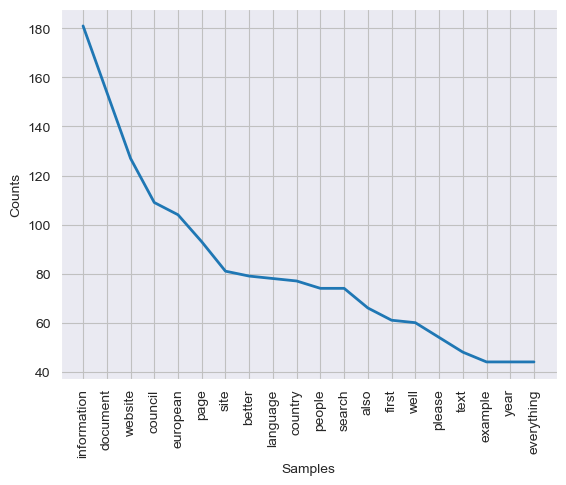

In [8]:
print('fil', tokenized_and_lemmatized_answers_Q11[0])
tokens = []
for lista in tokenized_and_lemmatized_answers_Q11:
    for word in lista:
        tokens.append(word)


# tokens = nltk.word_tokenize(filtered_answers_Q11)
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

fil []


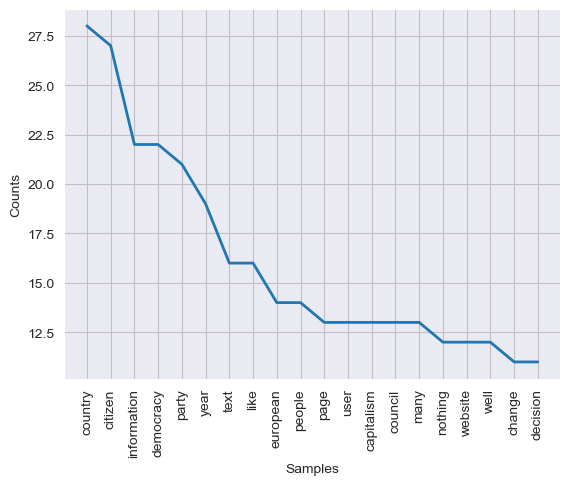

In [9]:
print('fil', tokenized_and_lemmatized_answers_Q12[2])
tokens = []
for lista in tokenized_and_lemmatized_answers_Q12:
    for word in lista:
        tokens.append(word)


sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

fil ['kebab']


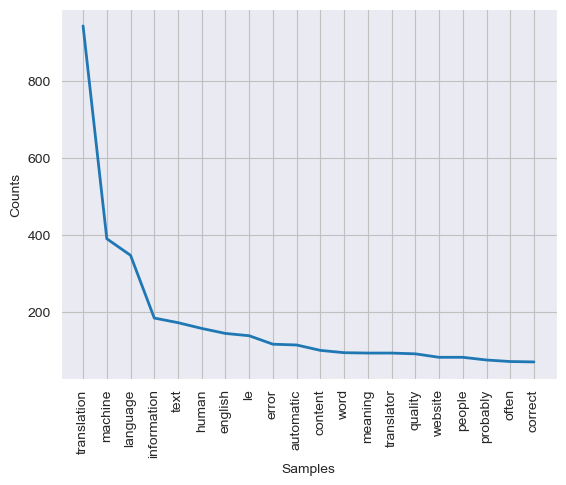

In [10]:
print('fil', tokenized_and_lemmatized_answers_Q14[2])
tokens = []
for lista in tokenized_and_lemmatized_answers_Q14:
    for word in lista:
        tokens.append(word)


# tokens = nltk.word_tokenize(filtered_answers_Q11)
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

## Non-negative Matrix Factorization model training and Topics assignment

In [11]:
# NMF Implementation (Q11)

tokenized_and_lemmatized_answers_Q11_tfidf = [
    ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3])
    for answer in filtered_answers_Q11
]

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(tokenized_and_lemmatized_answers_Q11_tfidf)

n_topics = 9

nmf_model = NMF(n_components=n_topics, random_state=42)
document_topics = nmf_model.fit_transform(X_tfidf)

# Display the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Display top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: moment, nothing, thing, next, maybe, certainly, page, many, improvement, first
Topic 1: information, country, useful, detailed, simple, date, much, member, precise, current
Topic 2: first, visit, opinion, since, survey, early, okay, right, maybe, enjoyable
Topic 3: comment, lack, work, even, overview, pleased, function, entire, recommendation, page
Topic 4: search, better, engine, function, content, little, fact, easier, daily, button
Topic 5: website, survey, much, great, catalan, clear, even, detail, perfect, start
Topic 6: document, language, official, translation, english, prado, available, country, easy, spanish
Topic 7: suggestion, soon, unfortunately, site, contribution, irregularity, therefore, expert, portal, thing
Topic 8: council, page, well, european, site, everything, clear, opinion, union, great


In [12]:
# Assign topics to each document based on the highest weight
assigned_topics = [np.argmax(topic_weights) for topic_weights in document_topics]

# Display the assigned topics for the first few documents
for i in range(0,2209):
    print(f"Document {i + 1}: Assigned Topic - {assigned_topics[i]} - actual doc: {text_data_set_1[i]}")

Document 1: Assigned Topic - 0 - actual doc: None
Document 2: Assigned Topic - 6 - actual doc: It would be more important to be more information on the type of security of documents or a description of how to verify the authenticity of a specific document
Document 3: Assigned Topic - 6 - actual doc: If made easy
Document 4: Assigned Topic - 0 - actual doc: No
Document 5: Assigned Topic - 6 - actual doc: Id like better and faster updates on official documents renewals.
Document 6: Assigned Topic - 8 - actual doc: I don't have experience to be shared yet but In a near future It will be different
Document 7: Assigned Topic - 5 - actual doc: Just very much
Document 8: Assigned Topic - 6 - actual doc: Nope, however, please make doners to 5 euros again, thanks.
Document 9: Assigned Topic - 0 - actual doc: D kdj
Document 10: Assigned Topic - 0 - actual doc: Not
Document 11: Assigned Topic - 3 - actual doc: Nope
Document 12: Assigned Topic - 6 - actual doc: Please update the data for a new Ukr

In [13]:
# NMF Implementation (Q12)

tokenized_and_lemmatized_answers_Q12_tfidf = [
    ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3])
    for answer in filtered_answers_Q12
]

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(tokenized_and_lemmatized_answers_Q12_tfidf)

n_topics = 9

nmf_model = NMF(n_components=n_topics, random_state=42)
document_topics = nmf_model.fit_transform(X_tfidf)

# Display the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Display top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: information, objective, document, relevant, need, recruitment, presentation, useful, complete, much
Topic 1: nothing, second, functioning, much, probably, page, european, party, text, well
Topic 2: everything, easier, euro, french, digital, people, party, citizen, democracy, like
Topic 3: truth, skin, pamphlet, face, without, instead, propaganda, site, straight, answer
Topic 4: page, clearer, user, significantly, regularly, please, design, second, spanish, fine
Topic 5: council, european, decision, member, union, le, country, migration, head, much
Topic 6: survey, employee, towards, arrogance, teacher, worth, possibility, nobody, otherwise, alone
Topic 7: website, interest, longer, user, attention, news, finally, nidea, something, ennemy
Topic 8: propaganda, back, change, people, le, instead, world, american, priority, governance


In [14]:
# Assign topics to each document based on the highest weight
assigned_topics_Q12 = [np.argmax(topic_weights) for topic_weights in document_topics]

# Display the assigned topics for the documents
for i in range(0,266):
    print(f"Document {i + 1}: Assigned Topic - {assigned_topics_Q12[i]} - actual doc: {text_data_set_2[i]}")

Document 1: Assigned Topic - 8 - actual doc: Improve the standard of living
Document 2: Assigned Topic - 8 - actual doc: Less propaganda
Document 3: Assigned Topic - 0 - actual doc: None
Document 4: Assigned Topic - 5 - actual doc: I am not intended in its content except for the data that are relevant in my country (EU cooperation with Panama)
Document 5: Assigned Topic - 6 - actual doc: Punctual explanation of what happens
Document 6: Assigned Topic - 0 - actual doc: Tun tun
Document 7: Assigned Topic - 0 - actual doc: I can not say
Document 8: Assigned Topic - 0 - actual doc: They can we nog
Document 9: Assigned Topic - 0 - actual doc: Current data, more accurate and more detailed information
Document 10: Assigned Topic - 8 - actual doc: Leave out American propaganda.
Document 11: Assigned Topic - 5 - actual doc: Much more precise data.
Document 12: Assigned Topic - 1 - actual doc: Nothing
Document 13: Assigned Topic - 7 - actual doc: The EU should finally be blown up, then you no lo

In [15]:
# NMF Implementation (Q14)

tokenized_and_lemmatized_answers_Q14_tfidf = [
    ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(answer.lower()) if word.isalnum() and word not in stop_words and len(word) > 3])
    for answer in filtered_answers_Q14
]

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(tokenized_and_lemmatized_answers_Q14_tfidf)

n_topics = 9

nmf_model = NMF(n_components=n_topics, random_state=42)
document_topics = nmf_model.fit_transform(X_tfidf)

# Display the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Display top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: translation, error, automatic, correct, always, accurate, human, meaning, incorrect, wrong
Topic 1: language, english, text, original, error, different, version, probably, people, another
Topic 2: le, trust, reliable, reliability, confidence, understandable, accurate, human, precise, correct
Topic 3: quality, poor, sure, reliability, impact, lower, probably, useful, translation, negative
Topic 4: information, much, probably, faster, longer, able, reliable, correctly, important, site
Topic 5: content, trust, confidence, difficult, faster, error, probably, accessible, longer, original
Topic 6: machine, human, often, translator, website, difficult, word, people, always, context
Topic 7: easier, english, faster, people, website, well, thing, many, much, mother
Topic 8: understanding, better, faster, text, human, reliability, everything, greater, misunderstanding, interpretation


In [16]:
# Assign topics to each document based on the highest weight
assigned_topics_Q14 = [np.argmax(topic_weights) for topic_weights in document_topics]

# Display the assigned topics for the documents
for i in range(0,2341):
    print(f"Document {i + 1}: Assigned Topic - {assigned_topics_Q14[i]} - actual doc: {text_data_set_3[i]}")

Document 1: Assigned Topic - 1 - actual doc: I am not convinced that the translation would be made in an accessible and understandable way and would be identical by keeping the nuances and specifics of each language (e.g. commonly used vocabulary or preferred words)
Document 2: Assigned Topic - 8 - actual doc: Fast and furious
Document 3: Assigned Topic - 8 - actual doc: None but I have to remember the kebab again
Document 4: Assigned Topic - 0 - actual doc: Hsj
Document 5: Assigned Topic - 7 - actual doc: It is easier to use in the native language
Document 6: Assigned Topic - 0 - actual doc: It's hard for me to judge but I'm afraid of an unreliable translation
Document 7: Assigned Topic - 1 - actual doc: AI cannot find the subtlety of the language. It is not so perfected.
Document 8: Assigned Topic - 6 - actual doc: If the machine translation were I would use English
Document 9: Assigned Topic - 7 - actual doc: I'm doing well
Document 10: Assigned Topic - 6 - actual doc: Bad reading o

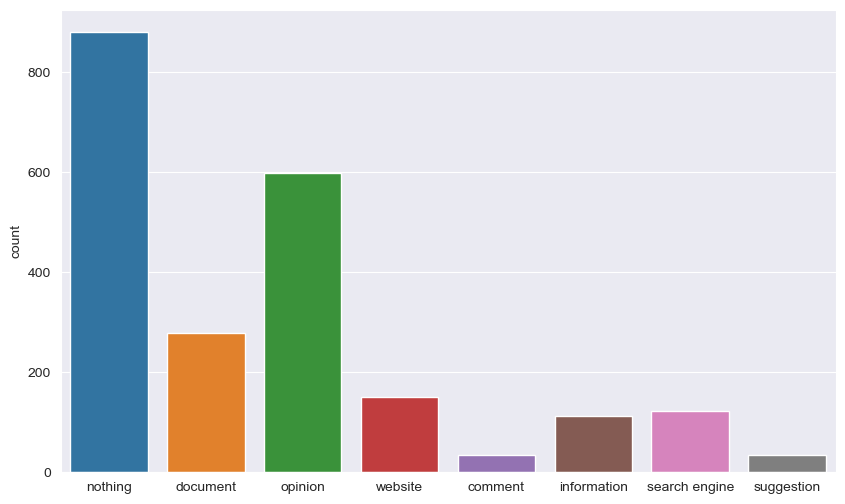

In [22]:
# Dictionary mapping numbers to strings
number_to_string = {
    0: 'nothing',
    1: 'information',
    2: 'nothing',
    3: 'comment',
    4: 'search engine',
    5: 'website',
    6: 'document',
    7: 'suggestion',
    8: 'opinion'
}

# Convert the numbers to strings using the dictionary
data_strings = [number_to_string[num] for num in assigned_topics]


plt.figure(figsize=(10, 6))

# Countplot for Q11
sns.countplot(x=data_strings)

# Show the plot
plt.show()

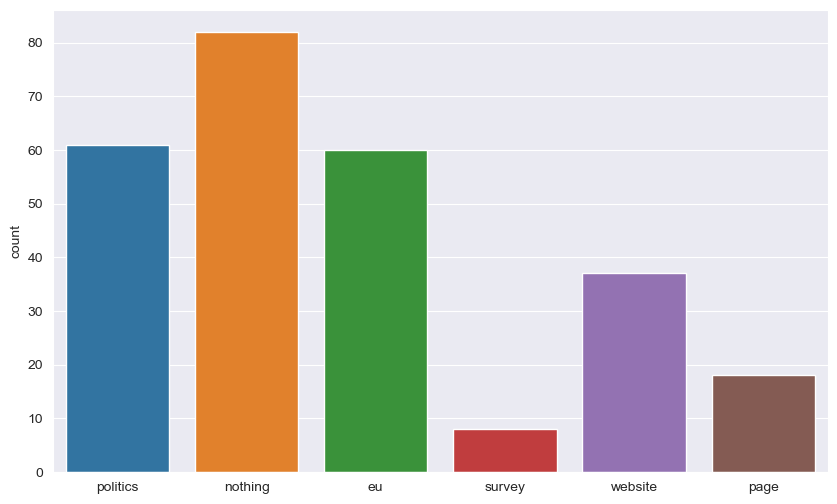

In [23]:
# Dictionary mapping numbers to strings
number_to_string = {
    0: 'nothing',
    1: 'nothing',
    2: 'nothing',
    3: 'nothing',
    4: 'page',
    5: 'eu',
    6: 'survey',
    7: 'website',
    8: 'politics'
}

# Convert the numbers to strings using the dictionary
data_strings = [number_to_string[num] for num in assigned_topics_Q12]


plt.figure(figsize=(10, 6))

# Countplot for Q11
sns.countplot(x=data_strings)

# Show the plot
plt.show()

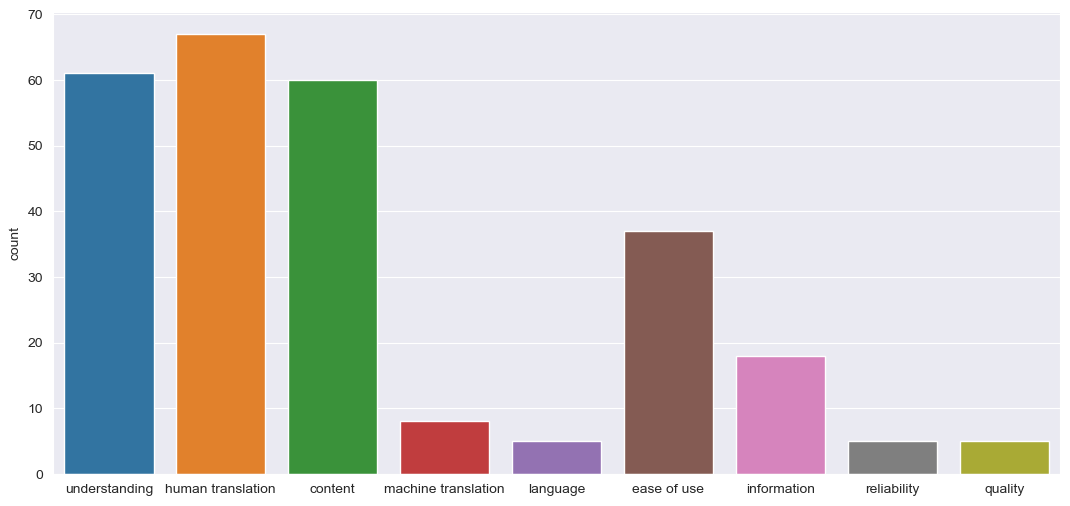

In [32]:
# Dictionary mapping numbers to strings
number_to_string = {
    0: 'human translation',
    1: 'language',
    2: 'reliability',
    3: 'quality',
    4: 'information',
    5: 'content',
    6: 'machine translation',
    7: 'ease of use',
    8: 'understanding'
}

# Convert the numbers to strings using the dictionary
data_strings = [number_to_string[num] for num in assigned_topics_Q12]


plt.figure(figsize=(13, 6))

# Countplot for Q11
sns.countplot(x=data_strings)

# Show the plot
plt.show()

## CSV and Excel creation

In [189]:
import csv

with open('Q11_topics_csv.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Original Text","Translated to English", "Topic"])
    for i in range(0,2209):
        topic = ''
        if assigned_topics[i] == 0:
            topic = 'nothing'
        elif assigned_topics[i] == 1:
            topic = 'information'
        elif assigned_topics[i] == 2:
            topic = 'nothing'
        elif assigned_topics[i] == 3:
            topic = 'comment'
        elif assigned_topics[i] == 4:
            topic = 'search engine'
        elif assigned_topics[i] == 5:
            topic = 'website'
        elif assigned_topics[i] == 6:
            topic = 'document'
        elif assigned_topics[i] == 7:
            topic = 'suggestion'
        else:
            topic = 'opinion'
        
        for token in tokenized_and_lemmatized_answers_Q11[i]:
            if (token == "email" or token == 'mail') and assigned_topics != 0:
                topic = 'email'
                    
            if token == "search":
                topic = 'search engine'
            
            if token == "translation":
                topic = 'translation'
            
            if token == 'passport':
                topic = 'passport'
            
            if token == 'document':
                topic = 'document'
            
            if token == 'language':
                topic = 'translation'
                
        if len(tokenized_and_lemmatized_answers_Q11[i]) == 0:
            topic = 'nothing'
                    
        
        writer.writerow([answer_df_1.iloc[i]['Native'],answer_df_1.iloc[i]['Translated to English'],topic])  
    
    
print("CSV file for Q11 writing complete.")  

CSV file for Q11 writing complete.


In [190]:
data = []
for i in range(0,2209):
        topic = ''
        if assigned_topics[i] == 0:
            topic = 'nothing'
        elif assigned_topics[i] == 1:
            topic = 'information'
        elif assigned_topics[i] == 2:
            topic = 'nothing'
        elif assigned_topics[i] == 3:
            topic = 'comment'
        elif assigned_topics[i] == 4:
            topic = 'search engine'
        elif assigned_topics[i] == 5:
            topic = 'website'
        elif assigned_topics[i] == 6:
            topic = 'document'
        elif assigned_topics[i] == 7:
            topic = 'suggestion'
        else:
            topic = 'opinion'
        
        for token in tokenized_and_lemmatized_answers_Q11[i]:
            if (token == "email" or token == 'mail') and assigned_topics != 0:
                topic = 'email'
                    
            if token == "search":
                topic = 'search engine'
            
            if token == "translation":
                topic = 'translation'
            
            if token == 'passport':
                topic = 'passport'
            
            if token == 'document':
                topic = 'document'
            
            if token == 'language':
                topic = 'translation'
                
        if len(tokenized_and_lemmatized_answers_Q11[i]) == 0:
            topic = 'nothing'
                
                    
        data.append([
            answer_df_1.iloc[i]['Native'],
            answer_df_1.iloc[i]['Translated to English'],
            topic
        ])
        
    
# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["Original Text", "Translated to English", "Topic"])

# Write the DataFrame to an Excel file
df.to_excel('Q11_topics_excel.xlsx', index=False)

print("Excel file for Q11 writing complete.")

Excel file for Q11 writing complete.


### Q12 files

In [196]:
import csv

with open('Q12_topics_csv.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Original Text","Translated to English", "Topic"])
    for i in range(0,266):
        topic = ''
        if assigned_topics_Q12[i] == 0:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 1:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 2:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 3:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 4:
            topic = 'page'
        elif assigned_topics_Q12[i] == 5:
            topic = 'eu'
        elif assigned_topics_Q12[i] == 6:
            topic = 'survey'
        elif assigned_topics_Q12[i] == 7:
            topic = 'website'
        else:
            topic = 'politics'
        
        for token in tokenized_and_lemmatized_answers_Q12[i]:
            if (token == "information") and assigned_topics_Q12[i] == 0:
                topic = 'information'
                
        if len(tokenized_and_lemmatized_answers_Q12[i]) == 0:
            topic = 'nothing'
                    
        
        writer.writerow([answer_df_2.iloc[i]['Native'],answer_df_2.iloc[i]['Translated to English'],topic])  
    
    
print("CSV file for Q12 writing complete.")  

CSV file for Q12 writing complete.


In [197]:
data_Q12 = []
for i in range(0,266):
        topic = ''
        if assigned_topics_Q12[i] == 0:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 1:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 2:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 3:
            topic = 'nothing'
        elif assigned_topics_Q12[i] == 4:
            topic = 'page'
        elif assigned_topics_Q12[i] == 5:
            topic = 'eu'
        elif assigned_topics_Q12[i] == 6:
            topic = 'survey'
        elif assigned_topics_Q12[i] == 7:
            topic = 'website'
        else:
            topic = 'politics'
        
        for token in tokenized_and_lemmatized_answers_Q12[i]:
            if (token == "information") and assigned_topics_Q12[i] == 0:
                topic = 'information'
                
        if len(tokenized_and_lemmatized_answers_Q12[i]) == 0:
            topic = 'nothing'
                
                    
        data_Q12.append([
            answer_df_2.iloc[i]['Native'],
            answer_df_2.iloc[i]['Translated to English'],
            topic
        ])
        
    
# Create a DataFrame from the data
df = pd.DataFrame(data_Q12, columns=["Original Text", "Translated to English", "Topic"])

# Write the DataFrame to an Excel file
df.to_excel('Q12_topics_excel.xlsx', index=False)

print("Excel file for Q12 writing complete.")

Excel file for Q12 writing complete.


### Q14 files

In [207]:
import csv

with open('Q14_topics_csv.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Original Text","Translated in English", "Topic"])
    for i in range(0,2341):
        topic = ''
        if assigned_topics_Q14[i] == 0:
            topic = 'human translation'
        elif assigned_topics_Q14[i] == 1:
            topic = 'language'
        elif assigned_topics_Q14[i] == 2:
            topic = 'reliability'
        elif assigned_topics_Q14[i] == 3:
            topic = 'quality'
        elif assigned_topics_Q14[i] == 4:
            topic = 'information'
        elif assigned_topics_Q14[i] == 5:
            topic = 'content'
        elif assigned_topics_Q14[i] == 6:
            topic = 'machine translation'
        elif assigned_topics_Q14[i] == 7:
            topic = 'ease of use'
        else:
            topic = 'understanding'
        
                
        if len(tokenized_and_lemmatized_answers_Q14[i]) == 0:
            topic = 'nothing'
                    
        
        writer.writerow([answer_df_3.iloc[i]['Native'],answer_df_3.iloc[i]['Translated in English'],topic])  
    
    
print("CSV file for Q14 writing complete.")  

CSV file for Q14 writing complete.


In [208]:
data_Q14 = []
for i in range(0,2341):
        topic = ''
        if assigned_topics_Q14[i] == 0:
            topic = 'human translation'
        elif assigned_topics_Q14[i] == 1:
            topic = 'language'
        elif assigned_topics_Q14[i] == 2:
            topic = 'reliability'
        elif assigned_topics_Q14[i] == 3:
            topic = 'quality'
        elif assigned_topics_Q14[i] == 4:
            topic = 'information'
        elif assigned_topics_Q14[i] == 5:
            topic = 'content'
        elif assigned_topics_Q14[i] == 6:
            topic = 'machine translation'
        elif assigned_topics_Q14[i] == 7:
            topic = 'ease of use'
        else:
            topic = 'understanding'
        
                
        if len(tokenized_and_lemmatized_answers_Q14[i]) == 0:
            topic = 'nothing'
                
                    
        data_Q14.append([
            answer_df_3.iloc[i]['Native'],
            answer_df_3.iloc[i]['Translated in English'],
            topic
        ])
        
    
# Create a DataFrame from the data
df = pd.DataFrame(data_Q14, columns=["Original Text", "Translated in English", "Topic"])

# Write the DataFrame to an Excel file
df.to_excel('Q14_topics_excel.xlsx', index=False)

print("Excel file for Q14 writing complete.")

Excel file for Q14 writing complete.
